In [1]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from argparse import Namespace

from sklearn.decomposition import PCA

from maskrcnn.postprocess.validate import L, gini, plot_scatter
from maskrcnn.postprocess.polygonize import load_anns

from scipy.spatial.distance import cdist

import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [2]:
import xgboost as xgb
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

In [3]:
# def gini_series(x): return gini(x.values)

def n_neighbor(coords, h):
    return (cdist(coords, coords, 'euclidean') < h).sum(axis=0).mean()

In [4]:
# image index data
IDX_IN_DIR = 'data/Experiment0/aoi.csv'
# download log data
LOG_IN_DIR = 'data/Experiment0/aoi_download_log.csv'

# census data
CEN_IN_DIR = 'data/Experiment0/census.csv'

# satellite derived data
SAT_IN_ANN_DIR = 'data/Mexico/Pred/infer/'
SAT_IN_IMG_DIR = 'data/Mexico/Image/'
SAT_IN_SHP_DIR = 'data/Experiment0/sat.shp'

# output path
OUT_DIR = 'data/Experiment0/Output/'

SAMPLE_NAME = '2019Oct9'

# renamed columns in census, translate to English
CEN_COLS = {
    'POBTOT': 'cen_pop',
    # 'VIVTOT': 'cen_house',  # duplicate-ish
    # 'TVIVHAB': 'cen_inhab',  # duplicate-ish
    'cen_asset_score_pca': 'cen_asset_score_pca',
    'cen_public_score_pca': 'cen_public_score_pca',
    'cen_durable_score_pca': 'cen_durable_score_pca',
    'cen_housing_score_pca': 'cen_housing_score_pca',
    # 'cen_asset_score_sum': 'cen_asset_score_sum',  # results very similar to PCA
    # 'VPH_SNBIEN': 'cen_nodurable',  # meh
    # 'VPH_1CUART': 'cen_1room',  # no signal
    'VPH_3YMASC': 'cen_3plusroom',
    'VPH_REFRI': 'cen_refri',
    'VPH_AUTOM': 'cen_autom',
    'VPH_C_ELEC': 'cen_elec',
    'VPH_PISODT': 'cen_floor',
    # 'VPH_AGUADV': 'cen_water',  # meh
    # 'VPH_EXCSA': 'cen_toilet',  # meh
    # 'VPH_DRENAJ': 'cen_drainage',  # meh
    # 'VPH_INTER': 'cen_internet'  # no signal
}

In [5]:
# read image index data frame
df_idx = pd.merge(pd.read_csv(IDX_IN_DIR), pd.read_csv(LOG_IN_DIR),
                  how='outer', on='index')
df_idx = df_idx.loc[:, ['index', 'ent', 'mun', 'loc', 'chip',
                        'status', 'lon_min', 'lon_max', 'lat_min', 'lat_max']]

In [6]:
# read census data
df_cen = pd.read_csv(CEN_IN_DIR)

# drop NA localities with no images
df_cen = pd.merge(
    df_cen,
    df_idx.groupby(['ent', 'mun', 'loc']).agg(
        no_missing=pd.NamedAgg(column='status',
                               aggfunc=lambda x: sum(pd.isna(x)))),
    how='outer',
    on=['ent', 'mun', 'loc'])
df_cen = df_cen.loc[df_cen['no_missing'] == 0, :]

In [7]:
db_cols = ['VPH_RADIO', 'VPH_TV', 'VPH_REFRI', 'VPH_LAVAD',
           'VPH_AUTOM', 'VPH_PC', 'VPH_TELEF', 'VPH_CEL', 'VPH_INTER']
housing_cols = ['VPH_PISODT', 'VPH_2YMASD', 'VPH_3YMASC']
public_cols = ['VPH_C_ELEC', 'VPH_AGUADV', 'VPH_EXCSA', 'VPH_DRENAJ']
vph_cols = db_cols + housing_cols + public_cols  # all

for cols, output_col in zip([db_cols, housing_cols, public_cols, vph_cols],
                            ['cen_durable_score_pca', 'cen_housing_score_pca',
                             'cen_public_score_pca', 'cen_asset_score_pca']):
    # compute asset score via pca
    centered = (df_cen.loc[:, cols].values -
                df_cen.loc[:, cols].values.mean(axis=0)[np.newaxis, :])
    m = PCA(n_components=1)
    df_cen.loc[:, output_col] = m.fit_transform(centered)

# # compute asset score via summing
# df_cen.loc[:, 'cen_asset_score_sum'] = df_cen.loc[:, vph_cols].sum(axis=1)

df_cen['cen_housing_score_pca'] *= -1
df_cen['cen_public_score_pca'] *= -1

In [8]:
# rename and select columns
df_cen = (df_cen.loc[:, ['ent', 'mun', 'loc', 'sample'] + list(CEN_COLS.keys())]
                .rename(columns=CEN_COLS))

In [9]:
if os.path.isfile(SAT_IN_SHP_DIR):
    df_sat = gpd.read_file(SAT_IN_SHP_DIR)
else:
    # read sat annotations
    ann_files = glob.glob(SAT_IN_ANN_DIR + '*.json')
    img_files = [os.path.join(SAT_IN_IMG_DIR,
                              (os.path.relpath(f, SAT_IN_ANN_DIR).replace('.json', '.png')))
                 for f in ann_files]
    df_sat = load_anns(ann_files=ann_files,
                       img_files=img_files,
                       idx_file=IDX_IN_DIR)
    df_sat = pd.merge(df_sat, df_idx, how='left', on='index')
    df_sat = df_sat.drop(columns=['RGB_mean', 'RGB_median'])
    df_sat = df_sat.loc[~df_sat.is_empty, :]
    df_sat.to_file(SAT_IN_SHP_DIR, index=False)

In [10]:
# grouping into localities
df_group = df_sat.groupby(['ent', 'mun', 'loc']).agg(
    sat_house=pd.NamedAgg(column='area', aggfunc='count'),
    sat_size_mean=pd.NamedAgg(column='area', aggfunc=np.nanmean),
#     sat_size_med=pd.NamedAgg(column='area', aggfunc=np.nanmedian),  # nah not better than mean
    sat_lum_mean=pd.NamedAgg(column='luminosity', aggfunc=np.nanmean),
    sat_saturation_mean=pd.NamedAgg(column='saturation', aggfunc=np.nanmean),
#     sat_size_gini=pd.NamedAgg(column='area', aggfunc=gini_series),  # no signal
    sat_size_sum=pd.NamedAgg(column='area', aggfunc=np.nansum)
)

In [11]:
# measure spatial clustering
tile_size = 1.6516e-3

for i, col in zip([.3, .53],
                  ['sat_nn_h30', 'sat_nn_h53']):
    df_group[col] = df_sat.groupby(['ent', 'mun', 'loc']).apply(
        lambda grp: n_neighbor(
            np.array([grp.centroid.x.values, grp.centroid.y.values]).T,
            h=tile_size * i))

# calculate K function values
# tile_size = 1.6516e-3
# for i, col in zip([.5, 1, 1.5],
#                   ['sat_dist_h05', 'sat_dist_h10', 'sat_dist_h15']):
#     df_group[col] = df_sat.groupby(['ent', 'mun', 'loc']).apply(
#         lambda grp: L(grp[['lon_center', 'lat_center']].values,
#                       A=(tile_size ** 2) * 25, h=tile_size * i))

In [12]:
# scale areas / distances
df_group[['sat_size_mean', 'sat_size_sum']] *= (
    ((tile_size / 800 * 111000) ** 2) * np.cos(23 / 180 * np.pi))  # in sq meters

In [13]:
df_group['sat_angle_align'] = df_sat.groupby(['ent', 'mun', 'loc']).apply(
    lambda grp: np.sort(np.histogram(
        grp['angle'].values,
        bins=9, range=(0, 90), density=True)[0] * 10)[-2:].sum())

In [14]:
# merge satellite and census
df_group = pd.merge(
    df_group,
    df_cen,
    how='right', on=['ent', 'mun', 'loc'])

In [15]:
# select sample
df_group = df_group.loc[df_group['sample'] == SAMPLE_NAME, :]

In [16]:
# df_group.loc[:, 'sat_size_sum_per_capita'] = df_group['sat_size_sum'] / df_group['cen_pop']

In [17]:
# # drop outliers
# df_group = df_group.loc[(
#     (df_group['sat_size_mean'] <= df_group['sat_size_mean'].quantile(q=0.98)) &
#     (df_group['sat_house'] <= df_group['sat_house'].quantile(q=0.97))
# ), :]

In [18]:
sat_cols = [col for col in df_group.columns if col.startswith('sat')]
cen_cols = [col for col in df_group.columns if col.startswith('cen')]

In [19]:
# params = {'objective': 'reg:squarederror',
#           'booster': 'gbtree',
#           'gamma': 0.3}

# X = df_group.loc[:, sat_cols].values
# y = df_group.loc[:, 'cen_asset_score_pca'].values

# # initialize k-fold
# kf = KFold(n_splits=5, shuffle=False, random_state=0)
# # instantiate model and output
# m = xgb.XGBRegressor(**params)
# val = []

# # cross validation
# for train_index, val_index in kf.split(X, y):

#     # train-test split
#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]

#     # fit regression model
#     m.fit(X_train, y_train)

#     # test output
#     y_val_pred = m.predict(X_val)
#     val.append(
#         pd.DataFrame({
#             'true': y_val,
#             'pred': y_val_pred}, index=val_index))

# val = pd.concat(val).sort_index()

# df_group.loc[:, 'sat_asset_score_pca_pred'] = val.loc[:, 'pred'].values

In [20]:
model = smf.ols('cen_asset_score_pca ~ sat_house + sat_size_mean', data=df_group)
res = model.fit()
df_group['sat_asset_score_pca_pred'] = res.fittedvalues

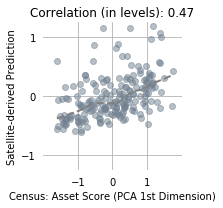

In [21]:
# prediction figure
plot_scatter(
    col_x_key='cen_asset_score_pca',
    col_x_label='Census: Asset Score (PCA 1st Dimension)',
    xlim=(-2.01, 2.01),
    xticks=[-1, 0, 1],
    col_y_key='sat_asset_score_pca_pred',
    col_y_label='Satellite-derived Prediction',
    ylim=(-1.25, 1.25),
    yticks=[-1, 0, 1],
    line=True, df=df_group,
    figsize=(3, 3),
    out_dir=OUT_DIR, show=True)

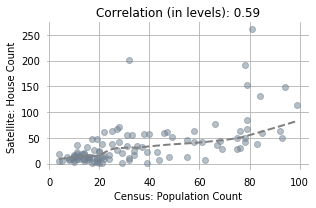

In [22]:
plot_scatter(
    col_x_key='cen_pop',
    col_x_label='Census: Population Count',
    col_y_key='sat_house',
    col_y_label='Satellite: House Count',
    line=True, df=df_group.loc[df_group['cen_pop'] < 100, :], out_dir=OUT_DIR, show=True)

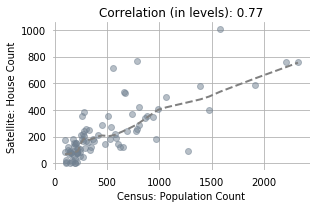

In [23]:
plot_scatter(
    col_x_key='cen_pop',
    col_x_label='Census: Population Count',
    col_y_key='sat_house',
    col_y_label='Satellite: House Count',
    line=True, df=df_group.loc[df_group['cen_pop'] >= 100, :], out_dir=OUT_DIR, show=True)

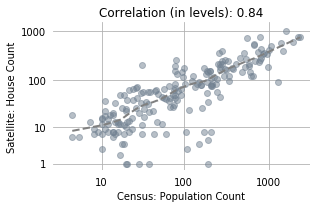

In [32]:
plot_scatter(
    col_x_key='cen_pop',
    col_x_label='Census: Population Count',
    transform_x=lambda x: np.log10(x + 1),
    xlim=(np.log10(2 + 1), np.log10(3000 + 1)),
    xticks=[np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
    xticklabels=[10, 100, 1000],
    col_y_key='sat_house',
    col_y_label='Satellite: House Count',
    transform_y=lambda x: np.log10(x + 1),
    ylim=(np.log10(0.5 + 1), np.log10(1500 + 1)),
    yticks=[np.log10(1 + 1), np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
    yticklabels=[1, 10, 100, 1000],
    line=True, df=df_group, out_dir=OUT_DIR, show=True)

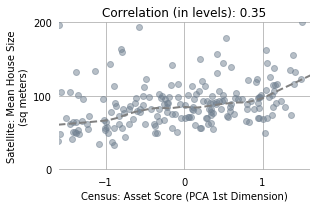

In [25]:
plot_scatter(
    col_x_key='cen_asset_score_pca',
    col_x_label='Census: Asset Score (PCA 1st Dimension)',
    xlim=(-1.6, 1.6),
    xticks=[-1, 0, 1],
    col_y_key='sat_size_mean',
    col_y_label='Satellite: Mean House Size\n(sq meters)',
    ylim=(-1, 200),
    yticks=[0, 100, 200],
    line=True, df=df_group, out_dir=OUT_DIR, show=True)

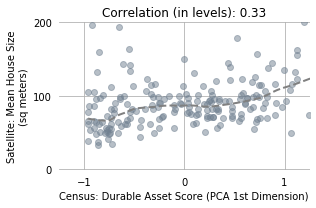

In [26]:
plot_scatter(
    col_x_key='cen_durable_score_pca',
    col_x_label='Census: Durable Asset Score (PCA 1st Dimension)',
    xlim=(-1.25, 1.25),
    xticks=[-1, 0, 1],
    col_y_key='sat_size_mean',
    col_y_label='Satellite: Mean House Size\n(sq meters)',
    ylim=(-1, 200),
    yticks=[0, 100, 200],
    line=True, df=df_group, out_dir=OUT_DIR, show=True)

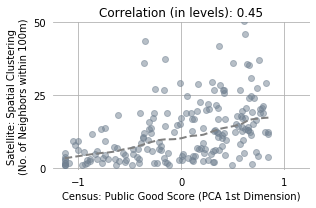

In [27]:
plot_scatter(
    col_x_key='cen_public_score_pca',
    col_x_label='Census: Public Good Score (PCA 1st Dimension)',
    xlim=(-1.25, 1.25),
    xticks=[-1, 0, 1],
    col_y_key='sat_nn_h53',
    col_y_label='Satellite: Spatial Clustering\n(No. of Neighbors within 100m)',
    ylim=(-0.5, 50),
    yticks=[0, 25, 50],
    line=True, df=df_group, out_dir=OUT_DIR, show=True)

In [28]:
# plot_scatter(
#     col_x_key='cen_3plusroom',
#     col_x_label='Census: Households Living in Houses with 3+ Rooms',
#     xticks=[0, .25, .5, .75, 1],
#     xticklabels=['0%', '25%', '50%', '75%', '100%'],
#     col_y_key='sat_size_mean',
#     col_y_label='Satellite: Mean House Size (sq meters)',
#     line=True, df=df_group, out_dir=OUT_DIR, show=True)

In [29]:
# # hand-picked figures
# plot_scatter(
#     col_x_key='cen_house',
#     col_x_label='Census: House Count',
#     transform_x=lambda x: np.log10(x + 1),
#     xlim=(np.log10(0 + 1.5), np.log10(1000 + 500)),
#     xticks=[np.log10(1 + 1), np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
#     xticklabels=[1, 10, 100, 1000],
#     col_y_key='sat_house',
#     col_y_label='Satellite: House Count',
#     transform_y=lambda x: np.log10(x + 1),
#     ylim=(np.log10(0 + 1.5), np.log10(1000 + 500)),
#     yticks=[np.log10(1 + 1), np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
#     yticklabels=[1, 10, 100, 1000],
#     square=True, df=df_group, out_dir=OUT_DIR, show=True)

In [30]:
# plot_scatter(
#     col_x_key='cen_asset_score1',
#     col_x_label='Census: Asset Score (PCA 1st Dimension)',
#     col_y_key='sat_size_gini',
#     col_y_label='Satellite: Gini Coefficient in House Size',
#     line=True, df=df_group, out_dir=OUT_DIR, show=True)

In [31]:
for f in glob.glob(os.path.join(OUT_DIR, 'all/*.pdf')):
    os.remove(f)
# massive plotting begins
for sat_col in sat_cols:
    for cen_col in cen_cols:
        plot_scatter(col_x_key=cen_col, col_y_key=sat_col,
                     col_x_label=cen_col, col_y_label=sat_col,
                     df=df_group, out_dir=os.path.join(OUT_DIR, 'all'))